## Playing around with DROID

In [92]:
from app.vjepa_droid.droid import *
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.spatial.transform import Rotation


In [123]:
path = "mydroiddata/dataset/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:19_2023"

In [124]:
metadata = get_json(path)

In [125]:
metadata

{'uuid': 'GuptaLab+553d1bd5+2023-04-20-12h-46m-19s',
 'lab': 'GuptaLab',
 'user': 'Mohan Kumar',
 'user_id': '553d1bd5',
 'date': '2023-04-20',
 'timestamp': '2023-04-20-12h-46m-19s',
 'hdf5_path': 'success/2023-04-20/Thu_Apr_20_12:46:19_2023/trajectory.h5',
 'building': 'Smith Hall Fetch Lab',
 'scene_id': 4481766701,
 'success': True,
 'robot_serial': '295341-1325237',
 'r2d2_version': '1.1',
 'current_task': 'Move object into or out of container (ex: drawer, clothes hamper, plate, trashcan, washer)',
 'trajectory_length': 159,
 'wrist_cam_serial': '16291792',
 'ext1_cam_serial': '22246076',
 'ext2_cam_serial': '26638268',
 'wrist_cam_extrinsics': [0.37157974363575014,
  0.15958970328019098,
  0.5392286171162175,
  3.0003403640561515,
  -0.25965870122743606,
  1.5007837893806812],
 'ext1_cam_extrinsics': [0.0625700860308161,
  0.7849934078474259,
  0.41321386028430906,
  -1.620310649739649,
  0.0378335771770526,
  -2.5025320852316324],
 'ext2_cam_extrinsics': [-0.05771166243442129,
 

In [126]:
tpath = os.path.join(path, "trajectory.h5")

In [127]:
trajectory = h5py.File(tpath)

In [128]:
camera_views=["left_mp4_path", "right_mp4_path"]

In [129]:
camera_view = camera_views[torch.randint(0, len(camera_views), (1,))]
mp4_name = metadata[camera_view].split("recordings/MP4/")[-1]
camera_name = mp4_name.split(".")[0]
mp4_name = metadata[camera_view].split("recordings/MP4/")[-1]
vpath = os.path.join(path, "recordings/MP4", mp4_name)
camera_view

'left_mp4_path'

In [130]:
vpath

'mydroiddata/dataset/droid_raw/1.0.1/GuptaLab/success/2023-04-20/Thu_Apr_20_12:46:19_2023/recordings/MP4/22246076.mp4'

In [131]:
extrinsics = trajectory["observation"]["camera_extrinsics"][f"{camera_name}_left"]

In [132]:
trajectory['observation'].keys()

<KeysViewHDF5 ['camera_extrinsics', 'camera_type', 'controller_info', 'robot_state', 'timestamp']>

In [133]:
states = np.concatenate(
            [
                np.array(trajectory["observation"]["robot_state"]["cartesian_position"]),
                np.array(trajectory["observation"]["robot_state"]["gripper_position"])[:, None],
            ],
            axis=1,
        )

In [134]:
states.shape

(159, 7)

In [135]:
xyz = states[:, :3]  # shape [T, 3]
thetas = states[:, 3:6]  # euler angles, shape [T, 3]
matrices = [Rotation.from_euler("xyz", theta, degrees=False).as_matrix() for theta in thetas]


In [136]:
thetas[0],matrices[0]

(array([-2.85047501,  0.19740698, -0.01918292]),
 array([[ 0.98039802, -0.07465735, -0.18233485],
        [-0.0188092 , -0.95666764,  0.29057398],
        [-0.19612734, -0.28144858, -0.93931931]]))

In [137]:
xyz_diff = xyz[1:] - xyz[:-1]

In [138]:
xyz_diff.shape

(158, 3)

In [139]:
xyz_diff.shape

(158, 3)

In [140]:
angle_diff = [matrices[t + 1] @ matrices[t].T for t in range(len(matrices) - 1)]
angle_diff = [Rotation.from_matrix(mat).as_euler("xyz", degrees=False) for mat in angle_diff]
angle_diff = np.stack([d for d in angle_diff], axis=0)

In [141]:
angle_diff[0]

array([ 2.97648261e-07, -1.95126684e-05,  8.47808105e-06])

In [142]:
closedness = states[:, -1:]
closedness_delta = closedness[1:] - closedness[:-1]
closedness_delta.shape

(158, 1)

In [143]:
actions = np.concatenate([xyz_diff, angle_diff, closedness_delta], axis=1)

In [144]:
xyz_diff.shape

(158, 3)

In [145]:
def visualize_action_trajectory(xyz_diff, angle_diff, closedness_delta):
    """
    Visualizes robot action deltas over time.
    
    Args:
        xyz_diff (np.array): Shape (T, 3) - Linear displacement (dx, dy, dz)
        angle_diff (np.array): Shape (T, 3) - Angular displacement (d_roll, d_pitch, d_yaw)
        closedness_delta (np.array): Shape (T, 1) - Gripper change
    """
    
    # Create a figure with 3 stacked subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Time axis (frames)
    frames = np.arange(len(xyz_diff))
    
    # --- Plot 1: Linear Velocity (XYZ) ---
    ax1 = axes[0]
    ax1.plot(frames, xyz_diff[:, 0], label='Delta X (Forward/Back)', color='r', alpha=0.8)
    ax1.plot(frames, xyz_diff[:, 1], label='Delta Y (Left/Right)', color='g', alpha=0.8)
    ax1.plot(frames, xyz_diff[:, 2], label='Delta Z (Up/Down)', color='b', alpha=0.8)
    ax1.set_ylabel('Displacement (m)')
    ax1.set_title('Linear Motion (Translation Velocity)')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--') # Zero line

    # --- Plot 2: Angular Velocity (Rotation) ---
    ax2 = axes[1]
    ax2.plot(frames, angle_diff[:, 0], label='Delta Roll', color='orange', alpha=0.8)
    ax2.plot(frames, angle_diff[:, 1], label='Delta Pitch', color='purple', alpha=0.8)
    ax2.plot(frames, angle_diff[:, 2], label='Delta Yaw', color='cyan', alpha=0.8)
    ax2.set_ylabel('Rotation (rad)')
    ax2.set_title('Angular Motion (Rotational Velocity)')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')

    # --- Plot 3: Gripper Actuation ---
    ax3 = axes[2]
    # Squeeze needed if shape is (T, 1) to make it (T,)
    ax3.plot(frames, closedness_delta.squeeze(), label='Gripper Delta', color='black')
    ax3.set_ylabel('Change')
    ax3.set_xlabel('Time (Frame Index)')
    ax3.set_title('Gripper Actuation (Open/Close Velocity)')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(0, color='red', linewidth=0.8, linestyle='--')
    
    # Add text annotation for interpretation
    ax3.text(0, ax3.get_ylim()[1], " Positive = Closing\n Negative = Opening", 
             verticalalignment='top', fontsize=9, bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

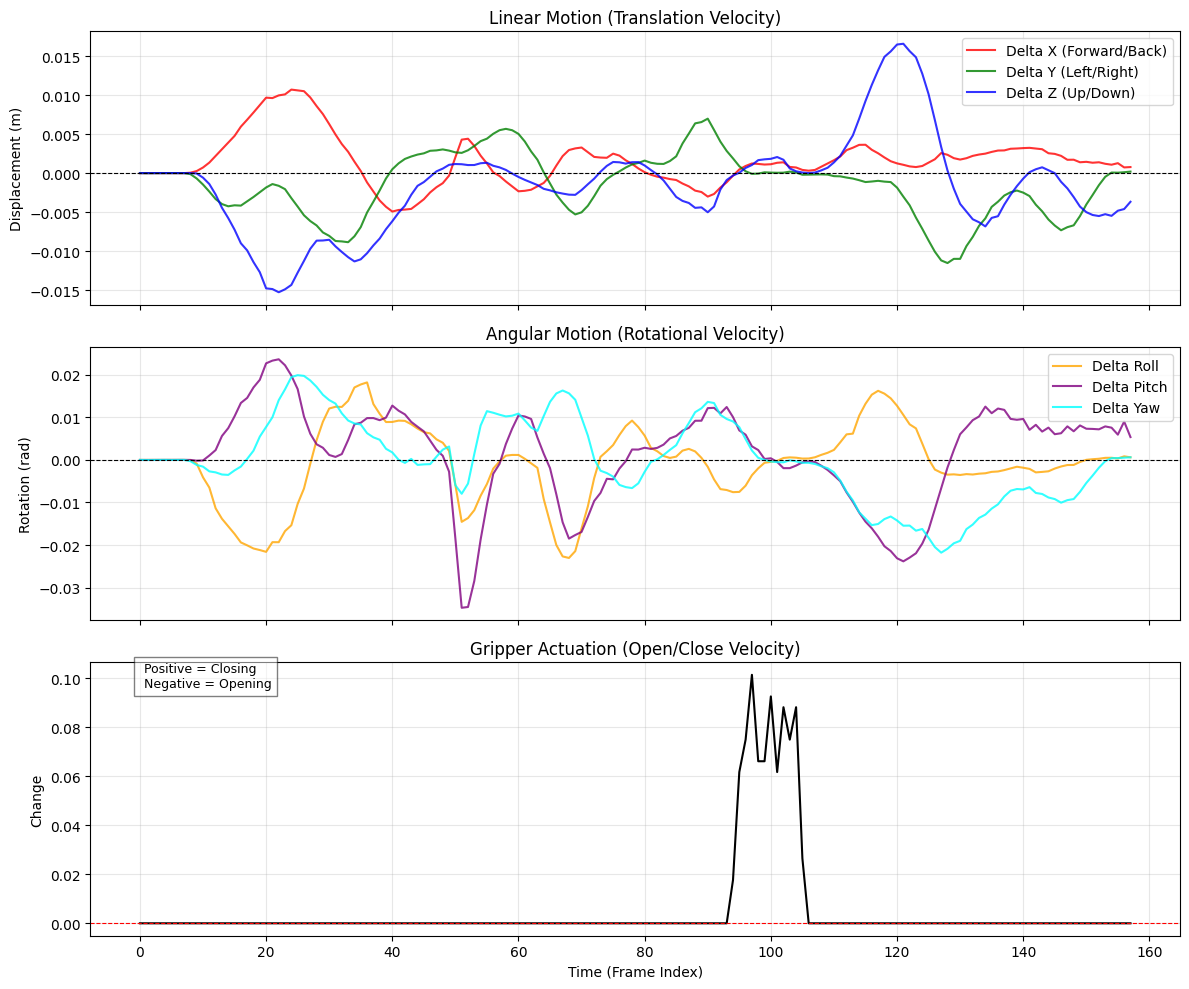

In [146]:
visualize_action_trajectory(xyz_diff, angle_diff, closedness_delta)

In [147]:
def visualize_droid_dashboard(states, stride=5, padding=0.1):
    """
    Creates a dashboard with:
    1. Top: Interactive 3D Trajectory (Fixed Scaling)
    2. Bottom: Time-series of Roll, Pitch, Yaw
    """
    # --- 1. Data Prep ---
    T = states.shape[0]
    indices = np.arange(T)
    x, y, z = states[:, 0], states[:, 1], states[:, 2]
    thetas = states[:, 3:6] # Roll, Pitch, Yaw
    gripper = states[:, 6]

    # Calculate Orientation for 3D Arrows (Cones)
    rot = Rotation.from_euler("xyz", thetas, degrees=False)
    local_vec = np.array([0, 0, 1]) 
    vecs = rot.apply(local_vec)
    u, v, w = vecs[:, 0], vecs[:, 1], vecs[:, 2]

    # Calculate Bounds for 1:1 Scaling (Same as before)
    min_x, max_x = x.min(), x.max()
    min_y, max_y = y.min(), y.max()
    min_z, max_z = z.min(), z.max()
    mid_x, mid_y, mid_z = (max_x+min_x)/2, (max_y+min_y)/2, (max_z+min_z)/2
    max_range = max(max_x-min_x, max_y-min_y, max_z-min_z)
    buffer = (max_range / 2) + padding

    # --- 2. Create Subplots Layout ---
    # Specs: Row 1 is a 3D scene. Row 2 is a standard 2D XY plot.
    fig = make_subplots(
        rows=2, cols=1,
        row_heights=[0.7, 0.3], # 3D plot takes 70% height
        vertical_spacing=0.05,
        specs=[[{"type": "scene"}], [{"type": "xy"}]],
        subplot_titles=("3D Trajectory (Color=Gripper)", "Orientation over Time (Roll/Pitch/Yaw)")
    )

    # --- 3. Add 3D Traces (Top Plot) ---
    
    # Path Line
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z, mode='lines+markers', name='Path',
        text=[f"Frame: {i}" for i in indices],
        marker=dict(size=3, color=gripper, colorscale='Bluered', showscale=False),
        line=dict(color='grey', width=3)
    ), row=1, col=1)

    # Orientation Cones
    fig.add_trace(go.Cone(
        x=x[::stride], y=y[::stride], z=z[::stride],
        u=u[::stride], v=v[::stride], w=w[::stride],
        sizemode="absolute", sizeref=0.08, anchor="tail",
        showscale=False, colorscale='Greys', name='Orientation', opacity=0.6
    ), row=1, col=1)

    # Start/End labels
    fig.add_trace(go.Scatter3d(
        x=[x[0]], y=[y[0]], z=[z[0]], mode='text', text=['START'],
        textfont=dict(color='green', size=10, weight='bold')
    ), row=1, col=1)
    fig.add_trace(go.Scatter3d(
        x=[x[-1]], y=[y[-1]], z=[z[-1]], mode='text', text=['END'],
        textfont=dict(color='red', size=10, weight='bold')
    ), row=1, col=1)

    # --- 4. Add 2D Traces (Bottom Plot) ---
    
    # Roll
    fig.add_trace(go.Scatter(
        x=indices, y=thetas[:, 0], mode='lines', name='Roll (X)',
        line=dict(color='orange', width=1.5)
    ), row=2, col=1)

    # Pitch
    fig.add_trace(go.Scatter(
        x=indices, y=thetas[:, 1], mode='lines', name='Pitch (Y)',
        line=dict(color='purple', width=1.5)
    ), row=2, col=1)

    # Yaw
    fig.add_trace(go.Scatter(
        x=indices, y=thetas[:, 2], mode='lines', name='Yaw (Z)',
        line=dict(color='cyan', width=1.5)
    ), row=2, col=1)


    # --- 5. Layout Polish ---
    fig.update_layout(
        title="DROID Robot Dashboard",
        height=900, width=800,
        showlegend=True,
        scene=dict(
            xaxis=dict(range=[mid_x-buffer, mid_x+buffer], title='X'),
            yaxis=dict(range=[mid_y-buffer, mid_y+buffer], title='Y'),
            zaxis=dict(range=[mid_z-buffer, mid_z+buffer], title='Z'),
            aspectmode='cube'
        )
    )
    
    # Add axis labels for 2D plot
    fig.update_xaxes(title_text="Frame Index", row=2, col=1)
    fig.update_yaxes(title_text="Angle (Radians)", row=2, col=1)

    fig.show()

# Usage:
# visualize_droid_dashboard(states)

In [148]:
# Usage:
visualize_droid_dashboard(states)

In [149]:
from IPython.display import Video, display
import os

def show_video(video_path, width=400, embed=True):
    """
    Displays an MP4 video inline in a Jupyter Notebook.
    
    Args:
        video_path (str): Path to the .mp4 file.
        width (int): Display width in pixels.
        embed (bool): If True, embeds the video data into the notebook (larger file size, 
                      but works even if the original video file is moved). 
                      If False, links to the file path (lighter notebook).
    """
    if not os.path.exists(video_path):
        print(f"Error: File not found at {video_path}")
        return

    print(f"Displaying: {os.path.basename(video_path)}")
    
    # Create the video object
    vid = Video(video_path, width=width, embed=embed, html_attributes="controls autoplay loop")
    
    # Render it
    display(vid)



In [150]:
show_video(vpath,width=1000)

Displaying: 22246076.mp4


In [122]:
states.shape , actions.shape

((211, 7), (210, 7))